In [34]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fit import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Sensitivity to PE (IE)

In [36]:
yoo = pd.read_pickle("data/yoo.pkl")
yoo['type'] = 'Human'
dg = pd.read_pickle("data/DG_yoo_apr1_dynamics.pkl")
# dg['type'] = "DeGroot"
dg['type'] = "Running\nAverage"
rl_l = pd.read_pickle("data/RL_l_yoo_apr2_dynamics.pkl")
rl_l['type'] = "Reinforcement\nLearning"
adm = pd.read_pickle("data/ADM_yoo_apr2_dynamics.pkl")
adm['type'] = "Averaging\nDiffusion"
nef = pd.read_pickle("data/NEF_syn_yoo_apr9_dynamics.pkl")
nef['type'] = "Neural\nNetwork"
combined = pd.concat([yoo, rl_l, adm, nef, dg], ignore_index=True)
dfs = []
columns = ['type', 'sid', 'trial', 'stage', 'deltaR']
# type_names = ['Human', "Reinforcement\nLearning", "Average\nDiffusion\nModel", "DeGroot"]
for mt, model_type in enumerate(combined['type'].unique()):
    for sid in combined['sid'].unique():
        print(model_type, sid)
        for trial in combined.query("type==@model_type & sid==@sid")['trial'].unique():
            stages = combined.query("type==@model_type & sid==@sid & trial==@trial")['stage'].unique()
            for s in range(len(stages)-1):
                # print(model_type, sid, trial, s)
                stage_old = stages[s]
                stage_new = stages[s+1]
                subdata = combined.query("type==@model_type & sid==@sid & trial==@trial")
                response_old = subdata.query("stage==@stage_old")['response'].to_numpy()[0]
                response_new = subdata.query("stage==@stage_new")['response'].to_numpy()[0]
                observation = yoo.query("sid==@sid & trial==@trial & stage==@stage_old")['observation'].to_numpy()[0]
                deltaR = np.abs(response_new - response_old)
                # dfs.append(pd.DataFrame([[type_names[mt], sid, trial, stage_old, deltaR]], columns=columns))
                dfs.append(pd.DataFrame([[model_type, sid, trial, stage_old, deltaR]], columns=columns))
deltaRs = pd.concat(dfs, ignore_index=True)

Human 1
Human 2
Human 3
Human 4
Human 5
Human 6
Human 7
Human 8
Human 10
Human 11
Human 13
Human 14
Human 15
Human 16
Human 17
Human 18
Human 19
Human 20
Human 21
Human 23
Human 24
Human 25
Human 26
Human 27
Human 29
Human 30
Human 32
Human 33
Human 34
Human 36
Human 37
Human 38
Human 39
Human 40
Human 41
Human 42
Human 44
Human 46
Reinforcement
Learning 1
Reinforcement
Learning 2
Reinforcement
Learning 3
Reinforcement
Learning 4
Reinforcement
Learning 5
Reinforcement
Learning 6
Reinforcement
Learning 7
Reinforcement
Learning 8
Reinforcement
Learning 10
Reinforcement
Learning 11
Reinforcement
Learning 13
Reinforcement
Learning 14
Reinforcement
Learning 15
Reinforcement
Learning 16
Reinforcement
Learning 17
Reinforcement
Learning 18
Reinforcement
Learning 19
Reinforcement
Learning 20
Reinforcement
Learning 21
Reinforcement
Learning 23
Reinforcement
Learning 24
Reinforcement
Learning 25
Reinforcement
Learning 26
Reinforcement
Learning 27
Reinforcement
Learning 29
Reinforcement
Learning 3

In [38]:
deltaRs.to_pickle("data/temporal_weighting.pkl")

# Plot deltaR vs stage for each sid

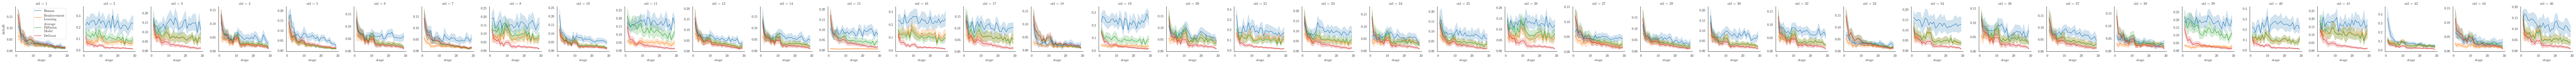

In [22]:
g = sns.FacetGrid(deltaRs, col="sid", sharey=False, sharex=True, legend_out=False)
g.map_dataframe(sns.lineplot, x="stage", y='deltaR', hue='type', palette=palette[:4])
g.add_legend()
g.savefig("plots/temporal_weighting_all_sid.jpg", dpi=100)
plt.show()

### Averaged over all models

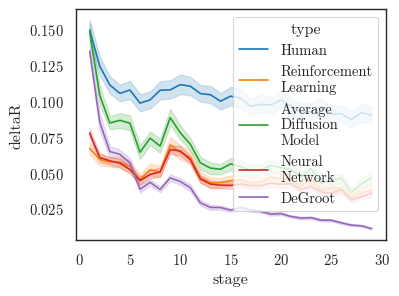

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
sns.lineplot(deltaRs, x='stage', y='deltaR', hue='type', palette=palette[:5])
fig.savefig("plots/temporal_weighting_averaged.jpg", dpi=600)

### Representative subjects

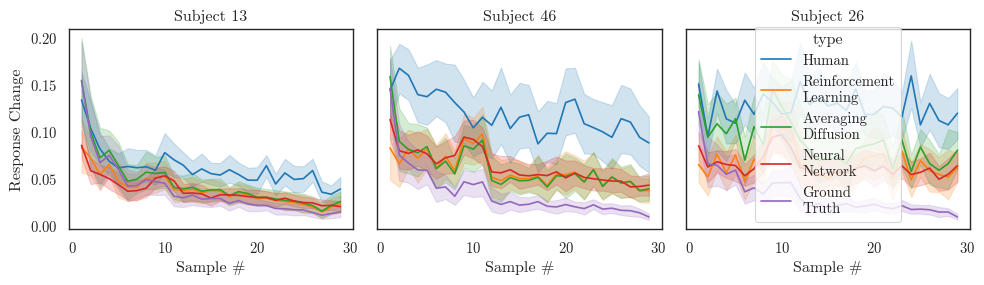

In [120]:
sid1 = 13  # 1 13 29
sid2 = 46  # 32 37 38 46
sid3 = 26  # 2 3 8 11 15 16 26
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=True, sharex=True)
sns.lineplot(deltaRs.query("sid==@sid1"), x='stage', y='deltaR', hue='type', palette=palette[:5], ax=axes[0])
sns.lineplot(deltaRs.query("sid==@sid2"), x='stage', y='deltaR', hue='type', palette=palette[:5], ax=axes[1])
sns.lineplot(deltaRs.query("sid==@sid3"), x='stage', y='deltaR', hue='type', palette=palette[:5], ax=axes[2])
axes[0].set(ylabel="Response Change", xlabel="Sample #", title=f"Subject {sid1}")
axes[1].set(ylabel=None, xlabel="Sample #", title=f"Subject {sid2}")
axes[2].set(ylabel=None, xlabel="Sample #", title=f"Subject {sid3}")
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.tight_layout()
plt.savefig("plots/updates_vs_stage.jpg", dpi=600)

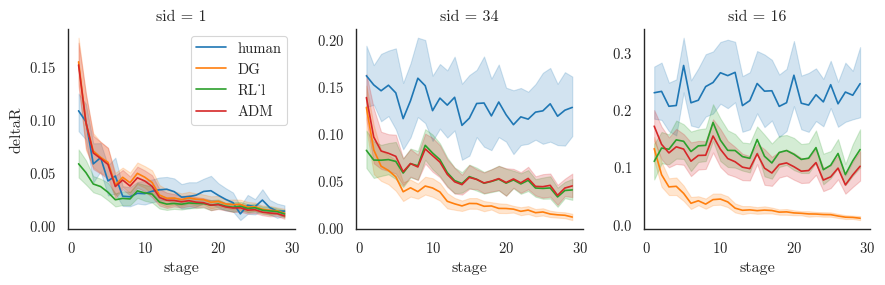

In [10]:
chosen_sids = [1, 34, 16]
g = sns.FacetGrid(deltaRs.query("sid==@chosen_sids"), col="sid", sharey=False, sharex=True, legend_out=False, col_order=chosen_sids)
g.map_dataframe(sns.lineplot, x="stage", y='deltaR', hue='type', palette=palette[:4])
g.add_legend()
g.savefig("plots/temporal_weighting_chosen_sid.jpg", dpi=100)
plt.show()

# Regress deltaR vs stage for each individual, plot distribution of slopes

In [23]:
def linear(x, slope, intercept):
    return intercept + slope * x

def inverse_power(x, slope, lambd):
    return slope / x**lambd

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

deltaRs = pd.read_pickle("data/temporal_weighting.pkl")
dfs = []
columns = ['type', 'sid', 'linear_p', 'linear_r2', 'linear_rmse', 'linear_change', 'power_p', 'power_r2', 'power_rmse', 'power_change']

for model_type in deltaRs['type'].unique():
    for sid in deltaRs['sid'].unique():
        subdata = deltaRs.query("type==@model_type & sid==@sid")
        X = subdata['stage'].to_numpy()
        Y = subdata['deltaR'].to_numpy()
        
        lin_slope, lin_intercept, r_value, lin_p_value, std_err = scipy.stats.linregress(X, Y)
        Y_linear = linear(X, lin_slope, lin_intercept)
        lin_r2 = r_value**2
        lin_r2_two = r_squared(Y, Y_linear)
        lin_rmse = rmse(Y, Y_linear)
        y_start = linear(1, lin_slope, lin_intercept)
        y_end = linear(30, lin_slope, lin_intercept)
        lin_change = (y_start - y_end) / y_start
        # print(lin_intercept, lin_slope, y_start, y_end, lin_change)
        # print(f"linear regression: p {lin_p_value:.4}, r2 {lin_r2:.4}, rmse {lin_rmse:.4}")  # r2 two {lin_r2_two},
        
        pow_params, pow_conv = scipy.optimize.curve_fit(inverse_power, X, Y, p0=[1.0, 1.0])
        pow_slope, pow_lambd = pow_params[0], pow_params[1]
        pow_pred = inverse_power(X, pow_slope, pow_lambd)
        pow_err = np.sqrt(np.diag(pow_conv))
        pow_t_vals = pow_params / pow_err
        pow_dof = max(0, len(X) - len(pow_params))
        pow_p_value = 2 * (1 - scipy.stats.t.cdf(np.abs(pow_t_vals[1]), df=pow_dof))
        Y_power = inverse_power(X, pow_slope, pow_lambd)   
        pow_r2 = r_squared(Y, Y_power)
        pow_rmse = rmse(Y, Y_power)
        y_start = inverse_power(1, pow_slope, pow_lambd)
        y_end = inverse_power(30, pow_slope, pow_lambd)
        pow_change = (y_start - y_end) / y_start
        # print(f"power regression: p {pow_p_value:.4}, r2 {pow_r2:.4}, rmse {pow_rmse:.4}")
        
        dfs.append(pd.DataFrame([[model_type, sid, lin_p_value, lin_r2, lin_rmse, lin_change,
                                                  pow_p_value, pow_r2, pow_rmse, pow_change]], columns=columns))
regression = pd.concat(dfs, ignore_index=True)
regression.to_pickle("data/temporal_weighting_regression.pkl")

In [135]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(deltaRs.query("type=='Human'")['stage'].to_numpy(),
                                                                      deltaRs.query("type=='Human'")['deltaR'].to_numpy())
print(r_value**2, p_value)
print(intercept, slope*30, 1-(intercept+slope*30)/intercept)

0.007574773151861457 1.3145189782338482e-56
0.11932304720133666 -0.03360286492092298 0.28161252758005806


In [148]:
# regression.query("type=='Human'")

In [24]:
regression.query("type=='Human'")

,type,sid,linear_p,linear_r2,linear_rmse,linear_change,power_p,power_r2,power_rmse,power_change
0,Human,1,6.339673e-39,1.782489e-01,0.036172,0.933052,0.000000e+00,0.276914,0.033931,0.841032
1,Human,2,6.919332e-02,3.799166e-03,0.163245,0.142705,2.361743e-01,0.001645,0.163421,0.107583
2,Human,3,8.329011e-01,5.131109e-05,0.105282,0.018706,8.535084e-01,0.000038,0.105283,0.019167
3,Human,4,2.576893e-09,4.007391e-02,0.046045,0.494663,0.000000e+00,0.064488,0.045455,0.583882
4,Human,5,1.329193e-41,1.897861e-01,0.056619,0.809344,0.000000e+00,0.232622,0.055102,0.743511
5,Human,6,2.427456e-05,2.033285e-02,0.045659,0.307770,1.132650e-12,0.044163,0.045100,0.451719
6,Human,7,1.410784e-12,5.619076e-02,0.054518,0.569076,0.000000e+00,0.110892,0.052915,0.678051
7,Human,8,4.353749e-01,7.011285e-04,0.118076,0.068369,1.479762e-01,0.002213,0.117986,0.137365
8,Human,10,4.729511e-22,1.018636e-01,0.056374,0.635258,0.000000e+00,0.198239,0.053264,0.727740
9,Human,11,9.782113e-01,8.598457e-07,0.108803,0.002050,6.790130e-01,0.000203,0.108792,-0.037743


In [12]:
regression.query("type=='Human' & linear_p<0.0001").shape

(22, 8)

In [28]:
regression.query("type=='Human' & power_p<0.0001").shape

(22, 10)

In [27]:
percent_change = 0.5
print(regression.query("type=='Human' & linear_change>@percent_change").shape)
print(regression.query("type=='Human' & power_change>@percent_change").shape)

(11, 10)
(14, 10)


In [29]:
regression.query("type=='Human' & linear_p<0.0001 & power_p<0.0001 & power_r2>linear_r2").shape

(19, 10)

In [30]:
regression.query("type=='Human' & linear_p<0.0001 & power_p<0.0001 & power_rmse<linear_rmse").shape

(19, 10)

In [32]:
regression.query("type=='Human' & linear_p<0.0001 & power_p<0.0001 & power_p<0.0001 & power_r2>linear_r2 & power_rmse<linear_rmse")

,type,sid,linear_p,linear_r2,linear_rmse,linear_change,power_p,power_r2,power_rmse,power_change
0,Human,1,6.339673e-39,0.178249,0.036172,0.933052,0.000000e+00,0.276914,0.033931,0.841032
3,Human,4,2.576893e-09,0.040074,0.046045,0.494663,0.000000e+00,0.064488,0.045455,0.583882
4,Human,5,1.329193e-41,0.189786,0.056619,0.809344,0.000000e+00,0.232622,0.055102,0.743511
5,Human,6,2.427456e-05,0.020333,0.045659,0.307770,1.132650e-12,0.044163,0.045100,0.451719
6,Human,7,1.410784e-12,0.056191,0.054518,0.569076,0.000000e+00,0.110892,0.052915,0.678051
8,Human,10,4.729511e-22,0.101864,0.056374,0.635258,0.000000e+00,0.198239,0.053264,0.727740
10,Human,13,9.463724e-20,0.090947,0.046273,0.595016,0.000000e+00,0.132444,0.045205,0.642831
11,Human,14,1.524887e-07,0.031267,0.054536,0.440723,0.000000e+00,0.056375,0.053825,0.560583
15,Human,18,1.557819e-09,0.041158,0.040860,0.723221,0.000000e+00,0.114215,0.039272,0.838932
17,Human,20,2.835216e-05,0.019999,0.053364,0.321312,3.395397e-06,0.021575,0.053321,0.354053


### Fit a inverse power law curve to the data instead of a line

In [ ]:
dfs = []
columns = ['type', 'sid', 'slope', 'intercept', 'r_value', 'p_value', 'std_error', 'p_criteria', 'percent_change']
p_threshold = 0.0001
slope_threshold = 0.5
for model_type in deltaRs['type'].unique():
    for sid in deltaRs['sid'].unique():
        subdata = deltaRs.query("type==@model_type & sid==@sid")
        stages = subdata['stage'].to_numpy()
        dRs = subdata['deltaR'].to_numpy()
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(stages, dRs)
        p_criteria = p_value < p_threshold
        percent_change = 1 - (intercept+slope*30)/intercept
        dfs.append(pd.DataFrame([[model_type, sid, slope, intercept, r_value, p_value, std_err, p_criteria, percent_change]], columns=columns))
regression = pd.concat(dfs, ignore_index=True)
regression.to_pickle("data/temporal_weighting_regression.pkl")

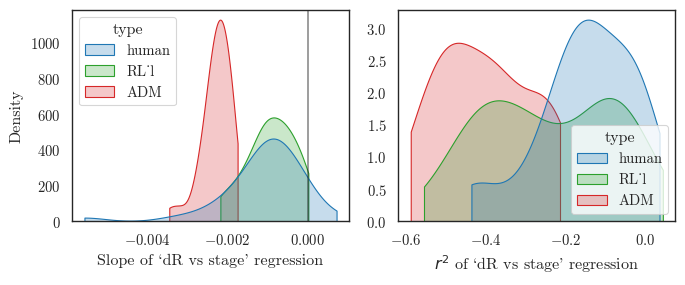

In [36]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6,3), sharex=True, sharey=True)
# sns.kdeplot(regression.query("type=='human'"), x='slope', fill=True, common_norm=False, label='human', cut=0, ax=axes[0])
# sns.kdeplot(regression.query("type=='RL_l'"), x='slope', fill=True, common_norm=False, label='RL_l', cut=0, ax=axes[1])
# sns.kdeplot(regression.query("type=='ADM'"), x='slope', fill=True, common_norm=False, label='ADM', cut=0, ax=axes[2])
# axes[0].set(title="human")
# axes[1].set(title="RL_l")
# axes[2].set(title="ADM")
palette2 = [palette[0], palette[2], palette[3]]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
sns.kdeplot(regression.query("type!='DG'"), x='slope', hue='type', fill=True, common_norm=False, cut=0, label='human', ax=axes[0], palette=palette2)
sns.kdeplot(regression.query("type!='DG'"), x='r-value', hue='type', fill=True, common_norm=False, cut=0, label='human', ax=axes[1], palette=palette2)
axes[0].set(xlabel="Slope of `dR vs stage' regression")
axes[1].set(xlabel=r"$r^2$ of `dR vs stage' regression", ylabel=None)
axes[0].axvline(0, color='k', alpha=0.5)
plt.tight_layout()
fig.savefig("plots/temporal_weighting_regression_distribution.jpg", dpi=600)

# Plot distribution of model parameters governing primacy vs recency

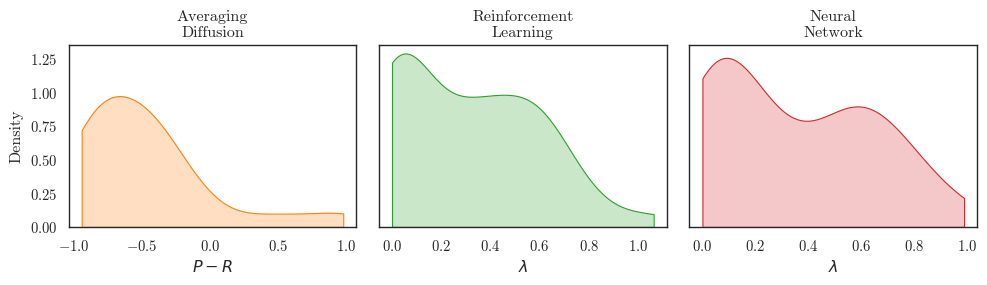

In [33]:
adm = pd.read_pickle("data/ADM_yoo_apr2_params.pkl")
rl = pd.read_pickle("data/RL_l_yoo_apr2_params.pkl")
nef = pd.read_pickle("data/NEF_syn_yoo_apr11_params.pkl")
primacy_minus_recency = adm['primacy'].to_numpy() - adm['recency'].to_numpy()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharey=True)
sns.kdeplot(primacy_minus_recency, fill=True, common_norm=False, cut=0, ax=axes[0], color=palette[1])
sns.kdeplot(rl, x='lambda', fill=True, common_norm=False, cut=0, ax=axes[1], color=palette[2])
sns.kdeplot(nef, x='lambda', fill=True, common_norm=False, cut=0, ax=axes[2], color=palette[3])
axes[0].set(xlabel=r"$P-R$", title="Averaging\nDiffusion")
axes[1].set(xlabel=r"$\lambda$", title="Reinforcement\nLearning")
axes[2].set(xlabel=r"$\lambda$", title="Neural\nNetwork")
plt.tight_layout()
fig.savefig("plots/lambda_distribution.jpg", dpi=600)

# Temporal weightning functions with fitted params

In [63]:
yoo = pd.read_pickle("data/yoo.pkl")
dfs = []
columns = ['type', 'sid', 'stage', 'weight']
max_stage = yoo['stage'].max()
for sid in yoo['sid'].unique():
    params_rl = pd.read_pickle("data/RL_l_yoo_apr2_params.pkl").query("sid==@sid").to_numpy()[0][2:]
    params_adm = pd.read_pickle("data/ADM_yoo_apr2_params.pkl").query("sid==@sid").to_numpy()[0][2:]
    ws_adm = []
    for stage in yoo['stage'].unique():
        w_rl = params_rl[0] * np.power(stage, -params_rl[1])
        w_adm = (1-(1-params_adm[0]**stage)*(1-params_adm[1]**(max_stage-stage+1))) * (1-params_adm[2]) + params_adm[2]
        dfs.append(pd.DataFrame([['RL_l', sid, stage, w_rl]], columns=columns))
        ws_adm.append(w_adm)
    ws_adm = np.array(ws_adm) / np.sum(ws_adm)
    for stage, w in enumerate(ws_adm):
        dfs.append(pd.DataFrame([['ADM', sid, stage+1, w]], columns=columns))
model_weights = pd.concat(dfs, ignore_index=True)
model_weights.to_pickle("data/temporal_weighting_model_weights.pkl")

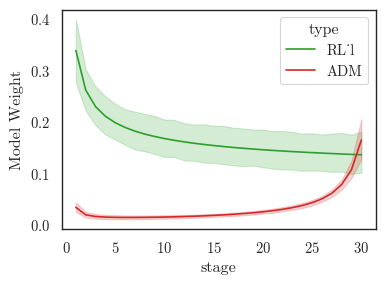

In [65]:
fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(model_weights, x='stage', y='weight', hue='type', palette=palette[2:4], ax=ax)
plt.tight_layout()
ax.set(ylabel='Model Weight')
fig.savefig("plots/temporal_weighting_model_weights_averaged.jpg", dpi=600)

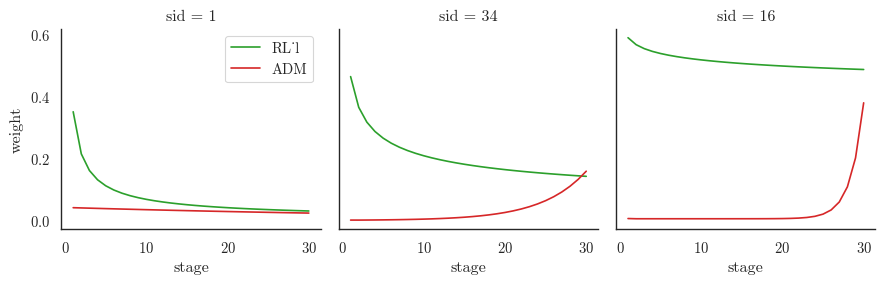

In [67]:
chosen_sids = [1, 34, 16]
g = sns.FacetGrid(model_weights.query("sid==@chosen_sids"), col="sid", sharey=True, sharex=True, legend_out=False, col_order=chosen_sids)
g.map_dataframe(sns.lineplot, x="stage", y='weight', hue='type', palette=palette[2:4])
g.add_legend()
g.savefig("plots/temporal_weighting_model_weights_chosen_sid.jpg", dpi=100)
plt.show()

# Rerun with different lambdas and plot resulting deltaRs

In [40]:
def run_and_get_deltaR(model_type, sid, lambd):
    if model_type=='human':
        params = []
    if model_type=='RL_l':
        p = pd.read_pickle("data/RL_l_yoo_apr2_params.pkl").query("sid==@sid")
        alpha = p['alpha'].unique()[0]
        params = [alpha, lambd]
    if model_type=='ADM':
        p = pd.read_pickle("data/ADM_yoo_apr2_params.pkl").query("sid==@sid")
        # primacy = p['primacy'].unique()[0]
        # recency = p['recency'].unique()[0]
        primacy = lambd
        recency = 0.5
        nu = p['nu'].unique()[0]
        params = [primacy, recency, nu]
    if model_type=='NEF_syn':
        p = pd.read_pickle("data/NEF_syn_yoo_apr9_params.pkl").query("sid==@sid")
        alpha = p['alpha'].unique()[0]
        n_neurons = p['n_neurons'].unique()[0]
        params = []
        data = run_NEF_syn("yoo", sid, alpha=alpha, z=0, lambd=lambd, n_neurons=n_neurons)

    yoo = pd.read_pickle(f"data/yoo.pkl").query("sid==@sid")
    dfs = []
    columns = ['type', 'sid', 'lambd', 'trial', 'stage', 'deltaR']
    for trial in yoo['trial'].unique():
        stages = yoo.query("trial==@trial")['stage'].unique()
        for s in range(len(stages)-1):
            # print(model_type, sid, trial, s)
            stage_old = stages[s]
            stage_new = stages[s+1]
            if model_type=='human':
                response_old = yoo.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
                response_new = yoo.query("trial==@trial & stage==@stage_new")['response'].to_numpy()[0]
            else:
                response_old = get_expectations_yoo(model_type, params, sid, trial, stage_old, yoo)
                response_new = get_expectations_yoo(model_type, params, sid, trial, stage_new, yoo)
            observation = yoo.query("trial==@trial & stage==@stage_old")['observation'].to_numpy()[0]
            deltaR = np.abs(response_new - response_old)
            dfs.append(pd.DataFrame([[model_type, sid, lambd, trial, stage_old, deltaR]], columns=columns))
    deltaRs = pd.concat(dfs, ignore_index=True)
    return deltaRs

In [105]:
lambdas = [0.01, 0.5, 1.0]
# sids = [1, 34, 16]
sids = [26, 46, 13]
sid_for_params = 13

# dfs = []
# for sid in sids:
#     dfs.append(run_and_get_deltaR("human", sid, None))
# human = pd.concat(dfs, ignore_index=True)
# human['type'] = "Human"

# dfs = []
# for lambd in lambdas:
#     dfs.append(run_and_get_deltaR("ADM", sid_for_params, lambd))
# adm = pd.concat(dfs, ignore_index=True)
# adm['type'] = "Averaging\nDiffusion"

# dfs = []
# for lambd in lambdas:
#     dfs.append(run_and_get_deltaR("RL_l", sid_for_params, lambd))
# rl = pd.concat(dfs, ignore_index=True)
# rl['type'] = "Reinforcement\nLearning"

# dfs = []
# for lambd in lambdas:
#     dfs.append(run_and_get_deltaR("NEF_syn", sid_for_params, lambd))
# nef = pd.concat(dfs, ignore_index=True)
# nef['type'] = "Neural\nNetwork"
# nef.to_pickle("data/NEF_syn_deltaRs_vs_lambda.pkl")

In [102]:
# combined = pd.concat([human, adm, rl, nef], ignore_index=True)
# combined.to_pickle("data/update_vs_lambda.pkl")
combined = pd.read_pickle("data/update_vs_lambda.pkl")

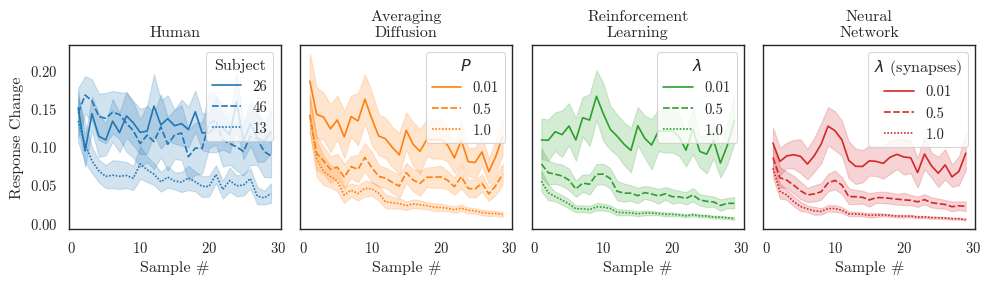

In [106]:
l_human = combined['type'].unique()[0]
l_adm = combined['type'].unique()[1]
l_rl = combined['type'].unique()[2]
l_nef = combined['type'].unique()[3]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3), sharey=True, sharex=True)
sns.lineplot(combined.query("type==@l_human"), x='stage', y='deltaR', ax=axes[0], color=palette[0], style='sid', style_order=sids)
sns.lineplot(combined.query("type==@l_adm"), x='stage', y='deltaR', ax=axes[1], color=palette[1], style='lambd')
sns.lineplot(combined.query("type==@l_rl"), x='stage', y='deltaR', ax=axes[2], color=palette[2], style='lambd')
sns.lineplot(combined.query("type==@l_nef"), x='stage', y='deltaR', ax=axes[3], color=palette[3], style='lambd')
axes[0].set(xlabel='Sample #', ylabel='Response Change')
axes[1].set(xlabel='Sample #')
axes[2].set(xlabel='Sample #')
axes[3].set(xlabel='Sample #')
axes[0].set(title='Human')
axes[1].set(title='Averaging\nDiffusion')
axes[2].set(title='Reinforcement\nLearning')
axes[3].set(title='Neural\nNetwork')
axes[0].legend(title="Subject", loc='upper right')
axes[1].legend(title=r"$P$")
axes[2].legend(title=r"$\lambda$")
axes[3].legend(title=r"$\lambda$ (synapses)")
plt.tight_layout()
fig.savefig("plots/updates_vs_lambda.jpg", dpi=600)

## load data with fitted lambda instead

In [108]:
def load_and_get_deltaR(model_type, sid):
    yoo = pd.read_pickle(f"data/yoo.pkl").query("sid==@sid")
    if model_type=='human':
        data = pd.read_pickle(f"data/yoo.pkl").query("sid==@sid")
        lambd = 0
    if model_type=='ADM':
        data = pd.read_pickle("data/ADM_yoo_apr25_dynamics.pkl").query("sid==@sid")
        P = pd.read_pickle("data/ADM_yoo_apr25_params.pkl").query("sid==@sid")['primacy'].unique()[0]
        R = pd.read_pickle("data/ADM_yoo_apr25_params.pkl").query("sid==@sid")['recency'].unique()[0]
        lambd = np.around(P - R, 3)
    if model_type=='RL_l':
        data = pd.read_pickle("data/RL_l_yoo_apr25_dynamics.pkl").query("sid==@sid")
        lambd = pd.read_pickle("data/RL_l_yoo_apr25_params.pkl").query("sid==@sid")['lambda'].unique()[0]
    if model_type=='NEF_syn':
        data = pd.read_pickle("data/NEF_syn_yoo_apr9_dynamics.pkl").query("sid==@sid")
        lambd = pd.read_pickle("data/NEF_syn_yoo_apr9_params.pkl").query("sid==@sid")['lambda'].unique()[0]
    dfs = []
    columns = ['type', 'sid', 'lambd', 'trial', 'stage', 'deltaR']
    for trial in yoo['trial'].unique():
        stages = yoo.query("trial==@trial")['stage'].unique()
        for s in range(len(stages)-1):
            stage_old = stages[s]
            stage_new = stages[s+1]
            response_old = data.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
            response_new = data.query("trial==@trial & stage==@stage_new")['response'].to_numpy()[0]
            observation = yoo.query("trial==@trial & stage==@stage_old")['observation'].to_numpy()[0]
            deltaR = np.abs(response_new - response_old)
            dfs.append(pd.DataFrame([[model_type, sid, lambd, trial, stage_old, deltaR]], columns=columns))
    deltaRs = pd.concat(dfs, ignore_index=True)
    return deltaRs

In [109]:
sids = [13, 46, 26]

dfs = []
for sid in sids:
    dfs.append(load_and_get_deltaR("human", sid))
    dfs.append(load_and_get_deltaR("ADM", sid))
    dfs.append(load_and_get_deltaR("RL_l", sid))
    dfs.append(load_and_get_deltaR("NEF_syn", sid))
combined_load = pd.concat(dfs, ignore_index=True)
combined_load.to_pickle("data/update_vs_lambda_load.pkl")

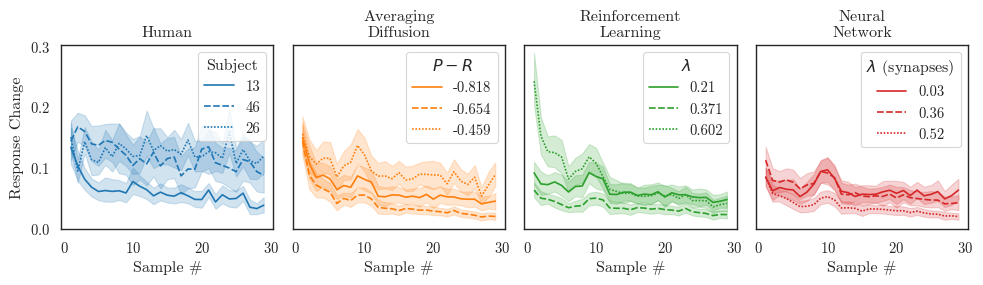

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3), sharey=True, sharex=True)
sns.lineplot(combined_load.query("type=='human'"), x='stage', y='deltaR', ax=axes[0], color=palette[0], style='sid', style_order=sids)
sns.lineplot(combined_load.query("type=='ADM'"), x='stage', y='deltaR', ax=axes[1], color=palette[1], style='lambd')
sns.lineplot(combined_load.query("type=='RL_l'"), x='stage', y='deltaR', ax=axes[2], color=palette[2], style='lambd')
sns.lineplot(combined_load.query("type=='NEF_syn'"), x='stage', y='deltaR', ax=axes[3], color=palette[3], style='lambd')
axes[0].set(xlabel='Sample #', ylabel='Response Change')
axes[1].set(xlabel='Sample #')
axes[2].set(xlabel='Sample #')
axes[3].set(xlabel='Sample #')
axes[0].set(title='Human')
axes[1].set(title='Averaging\nDiffusion')
axes[2].set(title='Reinforcement\nLearning')
axes[3].set(title='Neural\nNetwork')
axes[0].legend(title="Subject", loc='upper right')
axes[1].legend(title=r"$P-R$")
axes[2].legend(title=r"$\lambda$")
axes[3].legend(title=r"$\lambda$ (synapses)")
plt.tight_layout()
fig.savefig("plots/updates_vs_lambda_load.jpg", dpi=600)

# Carrabin

In [10]:
carrabin = pd.read_pickle("data/carrabin.pkl")
carrabin['type'] = 'human'
bayes = pd.read_pickle("data/B_n_carrabin_mar6_dynamics.pkl")
rl = pd.read_pickle("data/RL_n_carrabin_mar6_dynamics.pkl")
combined = pd.concat([carrabin, bayes, rl], ignore_index=True)
dfs = []
columns = ['type', 'sid', 'trial', 'stage', 'deltaR']
for model_type in combined['type'].unique():
    for sid in combined['sid'].unique():
        print(model_type, sid)
        for trial in combined.query("sid==@sid")['trial'].unique():
            stages = combined['stage'].unique()
            for s in range(len(stages)-1):
                stage_old = stages[s]
                stage_new = stages[s+1]
                subdata = combined.query("type==@model_type & sid==@sid & trial==@trial")
                response_old = subdata.query("stage==@stage_old")['response'].to_numpy()[0]
                response_new = subdata.query("stage==@stage_new")['response'].to_numpy()[0]
                observation = subdata.query("stage==@stage_old")['color'].to_numpy()[0]
                deltaR = np.abs(response_new - response_old)
                dfs.append(pd.DataFrame([[model_type, sid, trial, stage_old, deltaR]], columns=columns))
deltaRs = pd.concat(dfs, ignore_index=True)

human 1
human 2
human 3
human 4
human 5
human 6
human 7
human 8
human 9
human 10
human 11
human 12
human 13
human 14
human 15
human 16
human 17
human 18
human 19
human 20
human 21
B_n 1
B_n 2
B_n 3
B_n 4
B_n 5
B_n 6
B_n 7
B_n 8
B_n 9
B_n 10
B_n 11
B_n 12
B_n 13
B_n 14
B_n 15
B_n 16
B_n 17
B_n 18
B_n 19
B_n 20
B_n 21
RL_n 1
RL_n 2
RL_n 3
RL_n 4
RL_n 5
RL_n 6
RL_n 7
RL_n 8
RL_n 9
RL_n 10
RL_n 11
RL_n 12
RL_n 13
RL_n 14
RL_n 15
RL_n 16
RL_n 17
RL_n 18
RL_n 19
RL_n 20
RL_n 21


/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learnin

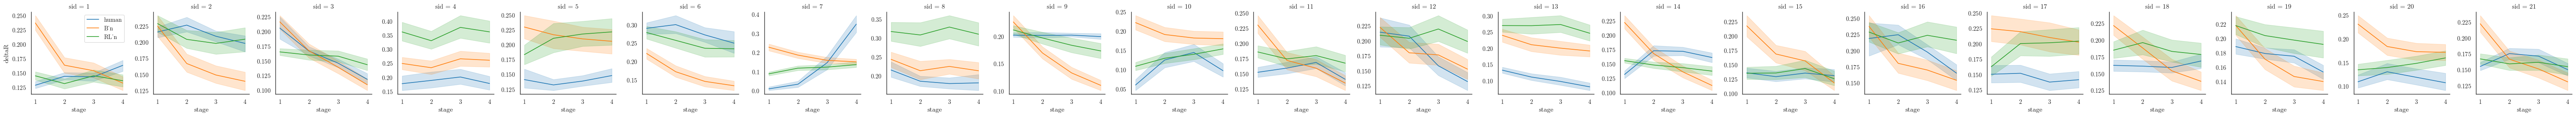

/tmp/ipykernel_41057/277412134.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(deltaRs, x='stage', y='deltaR', hue='type', palette=palette[:4])


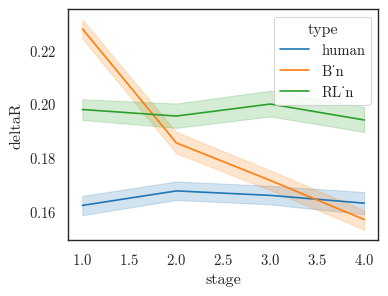

In [11]:
g = sns.FacetGrid(deltaRs, col="sid", sharey=False, sharex=True, legend_out=False)
g.map_dataframe(sns.lineplot, x="stage", y='deltaR', hue='type', palette=palette[:4])
g.add_legend()
g.savefig("plots/carrabin_temporal_weighting_all_sid.jpg", dpi=100)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
sns.lineplot(deltaRs, x='stage', y='deltaR', hue='type', palette=palette[:4])
fig.savefig("plots/carrabin_temporal_weighting_averaged.jpg", dpi=600)